# Navigate the U-turn using Monte Carlo learning

## 0) Setup

For the start, please execute the following cells.


In [2]:
import numpy as np
import random
from racetrack_environment import RaceTrackEnv
import matplotlib.pyplot as plt
import matplotlib.animation as animation
#from tqdm.notebook import tqdm
from tqdm import tqdm
from IPython.display import clear_output
plt.style.use('dark_background')

Execute the following cells to build a race track using the `RaceTrackEnv` as a test scenario.  

In [3]:
from utils import build_uturn_course

WWWWWWWWWWWW
WWWWW-oooooW
WWWWW-oooooW
WWWWW-oooooW
WWWWWWWWWooW
WWWWWWWWWooW
WWWWW+oooooW
WWWWW+oooooW
WWWWW+oooooW
WWWWWWWWWWWW


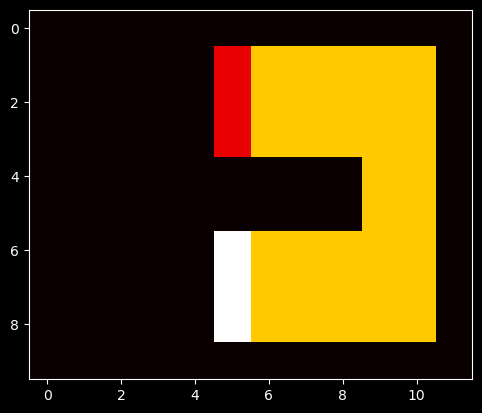

In [4]:
# Build the course
_course_dim = (8, 10)
_inner_wall_dim = (2, 6)

course = build_uturn_course(_course_dim, _inner_wall_dim)
track = RaceTrackEnv(course)
for row in course:
    print(row)

pos_map = track.course  # overlay track course
plt.imshow(pos_map, cmap='hot', interpolation='nearest')
plt.show()

### Testing the Race Track Environment
Please make yourself familiar with the environment used in `race_track_environment.py` by testing it in the following cell.  
In each state, the cell waits for a keyboard input and uses the typed number as the action.  
If you type `c`, the loop will stop.  
After each step, the environment writes the reward, and if the state terminates or truncates, it writes "Episode ended. Resetting."

Last action: 1, reward:-1.0
terminated: False, truncated: False, state: (2, 5, -1, 0)


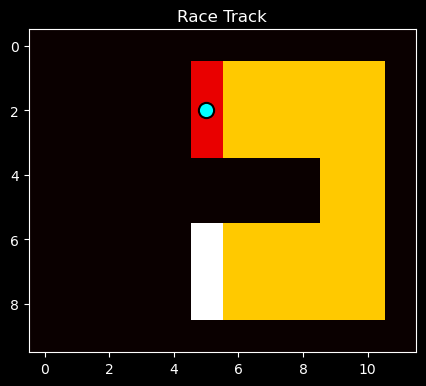

Invalid input.
Stopping control loop.


In [7]:

plt.ion()   # enable interactive plot
plt.figure(figsize=(5,5))

track.reset()
track.render()

while True:
    
    key = input("Enter action 0-8 (c to stop): ")

    if key.lower() == "c":
        print("Stopping control loop.")
        break

    # validate numeric input
    if not key.isdigit():
        print("Invalid input.")
        continue

    action = int(key)

    if action < 0 or action > 8:
        print("Action must be between 0 and 8.")
        continue
    clear_output(wait=True)
    
    # step environment
    next_state, reward, terminated, truncated, _ = track.step(action)
    
    print(f"Last action: {action}, reward:{reward}")
    print(f"terminated: {terminated}, truncated: {truncated}, state: {next_state}")
    #plt.clf() 
    track.render()

    if terminated or truncated:
        print("***************************")
        print("Episode ended. Resetting.")
        print("***************************")
        track.reset()
        track.render()

<img src="Direction_endcoding.png" width="20%">

## 1) Monte-Carlo-Based Prediction (Policy Evaluation)

Write a first-visit Monte-Carlo algorithm to evaluate the dummy policy as defined below on the U-turn course. The dummy policy turns the car to the right as soon as it stands in front of a wall. Try to understand how the policy works before you start to code.
Think about what the different dimensions of the policy array encode. It might be helpful to print parts of the array for visualization.

How can we interprete the state values resulting from the evaluation with first-visit Monte-Carlo?

In [8]:
# Select course and initialize dummy policy

course = build_uturn_course(_course_dim, _inner_wall_dim)
track = RaceTrackEnv(course)
dummy_slow_pi = np.ones([track.bounds[0], track.bounds[1], 1+2*track.MAX_VELOCITY, 1+2*track.MAX_VELOCITY]) * 4 

dummy_slow_pi[:track.bounds[0]//2, :, 0 , 0] = 5  # accelerate right
dummy_slow_pi[:track.bounds[0]//2, -2:, 0, :] = 6  # accelerate bottom left
dummy_slow_pi[-2:, track.bounds[1]//2:, :, 0] = 0  # accelerate top left

pi = dummy_slow_pi

The simple and deterministic dummy policy will always guarantee the car to reach the finish line. Thus, the state values can be interpreted as the number of timesteps that is necessary to reach the goal from that specific state (i.e. position and velocity) if we are following the policy.

In simple words, the policy acts as follows:
- ```dummy_slow_pi[:track.bounds[0]//2, :, 0, 0] = 5```: This part of the policy accelerates the car to the right when it is located anywhere in the upper half of the track bounds (first two dimensions) and has no velocity, i.e. is standing still (last two dimensions). This means that this part of the policy accelerates the car to a maximum velocity of ```v_x = 1```. As the car is not affected by this after it is already moving.
- ```dummy_slow_pi[:track.bounds[0]//2, -2:, 0, :] = 6```: This part of the policy takes effect when the car is in the upper half of the right boundary of the track. It only affects the car, when there is no vertical velocity (3rd dimension). As the car reaches this area of the space with the velocity ```v_x = 1``` and ```v_y = 0```, the velocity is ```v_x = 0``` and ```v_y = 1``` after this part of the policy was applied once. 
- ```dummy_slow_pi[-2:, track.bounds[1]//2:, :, 0] = 0```: This part of the policy takes effect when the car is at the right half of the lower boundary of the track. It only affects the car, when there is no horizontal velocity (4th dimension). As the car reaches this area of the space with the velocity ```v_x = 0``` and ```v_y = -1```, the velocity is ```v_x = -1``` and ```v_y = 0``` after this part of the policy was applied once.

Overall, we can see that the absolute value of the car's velocity never goes above 1. While this makes the movement of the car manageable, this is not the fastest way to get through the track.

In [ ]:
# --- Global setup for the tasks ---
_course_dim = (10, 12)
_inner_wall_dim = (6, 6) # Approximate inner wall dimensions resulting from 3-wide path

# Select course and initialize dummy policy
course = build_uturn_course(_course_dim, _inner_wall_dim)
track = RaceTrackEnv(course)

dummy_slow_pi = np.ones([track.bounds[0], track.bounds[1], 1+2*track.MAX_VELOCITY, 1+2*track.MAX_VELOCITY], dtype=int) * 4 
dummy_slow_pi[:track.bounds[0]//2, :, 0 , 0] = 5  # accelerate right
dummy_slow_pi[:track.bounds[0]//2, -2:, 0, :] = 6  # accelerate bottom left
dummy_slow_pi[-2:, track.bounds[1]//2:, :, 0] = 0  # accelerate top left
pi = dummy_slow_pi


# --- Solutions ---

def interact(pi, state):
    """Interact with the environment to get to the next state.

    Args:
        pi:  A deterministic stationary policy.
            Type: numpy.ndarray
            Shape: (10, 12, 11, 11)
                • axis 0 → row coordinate of state      (0…9)
                • axis 1 → column coordinate            (0…11)
                • axis 2 → vertical velocity            (0…10)
                • axis 3 → horizontal velocity          (0…10)
            Entry type: integer action ∈ {0,1,…,8}
        state: The current state before interaction
            Type: tuple of 4 np.int8
            Shape: (4,)
            Contents: (row, col, v_row, v_col)
        

    Returns:
        next_state: The next state after interaction
        reward: The reward for the current interaction
        terminated: If the goal was reached
        truncated: If the boundary of the track was breached
    """
    # Use the policy array to get the integer action for the current state
    action_int = pi[state]
    
    # Convert integer action to tuple for the step function (optional if step handles ints, but safe)
    # The provided step function handles ints via action_to_tuple check, but let's be explicit
    action_tuple = track.action_to_tuple(action_int)
    
    # Interact with the environment
    # Note: track.step returns 5 values (s, r, term, trunc, info)
    next_state, reward, terminated, truncated, _ = track.step(action_tuple)
    
    return next_state, reward, terminated, truncated

def gather_experience(pi, max_episode_len):
    """Simulate a full episode of data by repeatedly interacting with the environment.

    End the episode when the finish line is reached. Whenever the car leaves the track, simply
    reset the environment.
    
    Args:
        pi: The policy to apply
            Same indexing convention as in interact().
        max_episode_len: The number of steps at which the episode is terminated automatically

    Returns:
        states: All states that were visited in the episode
            Type: list of tuples
            Length: T  (T ≤ max_episode_len)
            Each element shape: (4,) tuple of np.int8

            Example (max_episode_len=2):
            states length = 2
            states = [(3,5,0,0), (3,6,0,1)]
            
        rewards: All rewards that were acquired in the episode
            Type: list of floats
            Length: T
            Each item shape: scalar float

            Example: [-1.0, -1.0]
            
        visited_states: The unique states that were visited in the episode
            Type: set of tuples
            Each tuple: shape (4,), np.int8
            Size: ≤ T   (unique states only)

            Example:
            {(3,5,0,0), (3,6,0,1)}
            
        first_visit_list: Whether it was the first time in the episode that the
            state at the same index was visited
            Type: list of booleans
            Length: T
            first_visit_list[t] = True if states[t] is first visit in episode

            Example: [True, True]
    """
    states = []
    rewards = []
    visited_states = set()
    first_visit_list = []
    
    # Reset environment
    current_state = track.reset()
    
    # To track first visits within *this* episode
    episode_visited_set = set()
    
    for k in range(max_episode_len):
        
        # Save momentary state
        states.append(current_state)
        
        # Check for first_visit
        if current_state not in episode_visited_set:
            first_visit_list.append(True)
            episode_visited_set.add(current_state)
            visited_states.add(current_state) # Add to unique set of visited states return
        else:
            first_visit_list.append(False)
        
        # Interact
        next_state, reward, terminated, truncated = interact(pi, current_state)
        rewards.append(reward)
        
        if terminated:
            # Terminate if finish line passed
            break
            
        if truncated:
            # Reset environment if car left track, but continue episode logic
            current_state = track.reset()
        else:
            current_state = next_state
            
    return states, rewards, visited_states, first_visit_list

def learn(values, n_dict, states, rewards, first_visit_list, gamma):
    """Learn from the collected data using the incremental first-visit MC-based prediction algorithm.

    Args:
        values: The state-value estimates before the current update step
        n_dict: The state visit counts before the current update step
            Type: dict
            Keys: states as 4-tuples
            Values: int (visit counts)
            
        states: All states that were visited in the last episode
            Type: list of tuples
            Length: T   (episode length)
            Each tuple: shape (4,), np.int8
            
        rewards: All rewards that were visited in the last episode
            Type: list of floats
            Length: T
            
        first_visit_list: Whether it was the first time in the episode that the
            state at the same index was visited
            Type: list of bool
            Length: T
            
        gamma: Discount factor

    Returns:
        values: The updated state-value estimates
            Same type and shape as input:
            numpy.ndarray of shape (10,12,11,11)
        n_dict: The state visit counts after the current update step
            Updated dict with visit counts
    """
    g = 0  
    # Loop backwards through the episode
    for state, reward, first_visit in zip(states[::-1], rewards[::-1], first_visit_list[::-1]): 
        # Calculate return (accumulate reward)
        g = gamma * g + reward
        
        # Update values if it is the first visit in the episode
        if first_visit:
            # Count visits to this state in n_dict
            if state not in n_dict:
                n_dict[state] = 0
            n_dict[state] += 1
            
            # Incremental mean update: V(s) <- V(s) + 1/N(s) * (G - V(s))
            values[state] += (1.0 / n_dict[state]) * (g - values[state])
            
    return values, n_dict

# --- Main Execution Loop ---

# initialize the value function
values = np.zeros([track.bounds[0], track.bounds[1], 1+2*track.MAX_VELOCITY, 1+2*track.MAX_VELOCITY])

# initialize an empty dict to count the number of visits
n_dict = {}

# configuration parameters
gamma = 1 # discount factor
no_episodes = 500 # number of evaluated episodes
max_episode_len = 2000 # number of allowed timesteps per episode

print("Starting Monte-Carlo Policy Evaluation...")
for e in tqdm(range(no_episodes), position=0, leave=True):
    states, rewards, visited_states, first_visit_list = gather_experience(pi, max_episode_len)
    values, n_dict = learn(values, n_dict, states, rewards, first_visit_list, gamma)

# --- Visualization ---

def text_print_pos_map(_pos_map):
    print("\nValue Map (Position Only):")
    for row in _pos_map:
        print(' '.join(['{:4d}'.format(int(r)) for r in row]))
        
def plot_pos_map(_pos_map):
    plt.figure(figsize=(8, 6))
    plt.imshow(_pos_map, cmap='hot', interpolation='nearest')
    plt.colorbar(label='Negative Value (Brighter = High Cost)')
    plt.title("State Values (min over velocities)")
    plt.show()

# calculate minimum value with respect to velocities
x_size, y_size = len(course[0]), len(course)
pos_map = np.zeros((y_size, x_size))
for s_x in range(x_size):
    for s_y in range(y_size):
        # We take the minimum (most negative) value to represent the worst-case cost-to-go
        pos_map[s_y, s_x] = np.min(values[s_y, s_x, :, :])
        
text_print_pos_map(pos_map)
# Plotting -pos_map so that 0 (goal) is dark and high costs (far away) are bright
plot_pos_map(-pos_map)


In [ ]:
# Function templates to help structure the code
# Note that the environment/track is a global variable here, so it does not need to be passed as an argument
# This is not a good practice in general, but it is done here to simplify the code
# You can therefore use the track variable directly in the functions
# e.g., track.reset()

def interact(pi, state):
    """Interact with the environment to get to the next state.

    Args:
        pi:  A deterministic stationary policy.
            Type: numpy.ndarray
            Shape: (10, 12, 11, 11)
                • axis 0 → row coordinate of state      (0…9)
                • axis 1 → column coordinate            (0…11)
                • axis 2 → vertical velocity            (0…10)
                • axis 3 → horizontal velocity          (0…10)
            Entry type: integer action ∈ {0,1,…,8}
        state: The current state before interaction
            Type: tuple of 4 np.int8
            Shape: (4,)
            Contents: (row, col, v_row, v_col)
        

    Returns:
        next_state: The next state after interaction
        reward: The reward for the current interaction
        terminated: If the goal was reached
        truncated: If the boundary of the track was breached
    """
    
    action = track.action_to_tuple(pi[state])
    next_state, reward, terminated, truncated, _ = track.step(action)

    return next_state, reward, terminated, truncated


def gather_experience(pi, max_episode_len):
    """Simulate a full episode of data by repeatedly interacting with the environment.

    End the episode when the finish line is reached. Whenever the car leaves the track, simply
    reset the environment.
    
    Args:
        pi: The policy to apply
            Same indexing convention as in interact().
        max_episode_len: The number of steps at which the episode is terminated automatically

    Returns:
        states: All states that were visited in the episode
            Type: list of tuples
            Length: T  (T ≤ max_episode_len)
            Each element shape: (4,) tuple of np.int8

            Example (max_episode_len=2):
            states length = 2
            states = [(3,5,0,0), (3,6,0,1)]
            
        rewards: All rewards that were acquired in the episode
            Type: list of floats
            Length: T
            Each item shape: scalar float

            Example: [-1.0, -1.0]
            
        visited_states: The unique states that were visited in the episode
            Type: set of tuples
            Each tuple: shape (4,), np.int8
            Size: ≤ T   (unique states only)

            Example:
            {(3,5,0,0), (3,6,0,1)}
            
        first_visit_list: Whether it was the first time in the episode that the
            state at the same index was visited
            Type: list of booleans
            Length: T
            first_visit_list[t] = True if states[t] is first visit in episode

            Example: [True, True]
    """
    states = []
    rewards = []
    visited_states = set()
    first_visit_list = []
    
    # Reset environment
    current_state = track.reset()
    
    # To track first visits within *this* episode
    episode_visited_set = set()
    
    for k in range(max_episode_len):
        
        # Save momentary state
        states.append(current_state)
        
        # Check for first_visit
        if current_state not in episode_visited_set:
            first_visit_list.append(True)
            episode_visited_set.add(current_state)
            visited_states.add(current_state) # Add to unique set of visited states return
        else:
            first_visit_list.append(False)
        
        # Interact
        next_state, reward, terminated, truncated = interact(pi, current_state)
        rewards.append(reward)
        
        if terminated:
            # Terminate if finish line passed
            break
            
        if truncated:
            # Reset environment if car left track, but continue episode logic
            current_state = track.reset()
        else:
            current_state = next_state
            
    return states, rewards, visited_states, first_visit_list

def learn(values, n_dict, states, rewards, first_visit_list, gamma):
    """Simulate a full episode of data by repeatedly interacting with the environment.

    End the episode when the finish line is reached. Whenever the car leaves the track, simply
    reset the environment.
    
    Args:
        pi: The policy to apply
            Same indexing convention as in interact().
        max_episode_len: The number of steps at which the episode is terminated automatically

    Returns:
        states: All states that were visited in the episode
            Type: list of tuples
            Length: T  (T ≤ max_episode_len)
            Each element shape: (4,) tuple of np.int8

            Example (max_episode_len=2):
            states length = 2
            states = [(3,5,0,0), (3,6,0,1)]
            
        rewards: All rewards that were acquired in the episode
            Type: list of floats
            Length: T
            Each item shape: scalar float

            Example: [-1.0, -1.0]
            
        visited_states: The unique states that were visited in the episode
            Type: set of tuples
            Each tuple: shape (4,), np.int8
            Size: ≤ T   (unique states only)

            Example:
            {(3,5,0,0), (3,6,0,1)}
            
        first_visit_list: Whether it was the first time in the episode that the
            state at the same index was visited
            Type: list of booleans
            Length: T
            first_visit_list[t] = True if states[t] is first visit in episode

            Example: [True, True]
    """
    g = 0  
    # Loop backwards through the episode
    for state, reward, first_visit in zip(states[::-1], rewards[::-1], first_visit_list[::-1]): 
        # Calculate return (accumulate reward)
        g = gamma * g + reward
        
        # Update values if it is the first visit in the episode
        if first_visit:
            # Count visits to this state in n_dict
            if state not in n_dict:
                n_dict[state] = 0
            n_dict[state] += 1
            
            # Incremental mean update: V(s) <- V(s) + 1/N(s) * (G - V(s))
            values[state] += (1.0 / n_dict[state]) * (g - values[state])
            
    return values, n_dict


In [10]:
# initialize the value function
values = np.zeros([track.bounds[0], track.bounds[1], 1+2*track.MAX_VELOCITY, 1+2*track.MAX_VELOCITY])

# initialize an empty dict to count the number of visits
# note that in the lecture the list l(x_k) was used for this purpose
n_dict = {}

# configuration parameters
gamma = 1 # discount factor
no_episodes = 500 # number of evaluated episodes
max_episode_len = 2000 # number of allowed timesteps per episode

for e in tqdm(range(no_episodes), position=0, leave=True):

    states, rewards, visited_states, first_visit_list = gather_experience(pi, max_episode_len)

    values, n_dict = learn(values, n_dict, states, rewards, first_visit_list, gamma)

100%|██████████| 500/500 [00:00<00:00, 540.29it/s]


To visualize the result of the evaluation, plot the state values as a function of **position only** (so that you get a two dimensional representation of the state value) and in the form of a tabular represenation and a heatmap. In order to omit dependence of the velocity dimensions, use the minimum of the value function with respect to the velocities.

000 000 000 000 000 000 000 000 000 000 000 000
000 000 000 000 000 -17 -16 -15 -14 -13 -12 000
000 000 000 000 000 -16 -15 -14 -13 -12 -11 000
000 000 000 000 000 -15 -14 -13 -12 -11 -10 000
000 000 000 000 000 000 000 000 000 000 -09 000
000 000 000 000 000 000 000 000 000 000 -08 000
000 000 000 000 000 000 000 000 000 000 -07 000
000 000 000 000 000 000 000 000 000 000 -06 000
000 000 000 000 000 000 -01 -02 -03 -04 -05 000
000 000 000 000 000 000 000 000 000 000 000 000


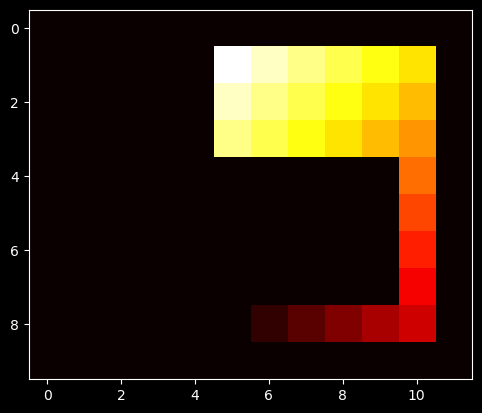

In [11]:
def text_print_pos_map(_pos_map):
    for row in _pos_map:
        print(' '.join(x_size*['{}']).format(*[str(int(r)).zfill(3) for r in row]))
        
def plot_pos_map(_pos_map):
    plt.imshow(_pos_map, cmap='hot', interpolation='nearest')
    plt.show()

# calculate minimum value with respect to velocities
x_size, y_size = len(course[0]), len(course)
pos_map = np.zeros((y_size, x_size))

for s_x in range(x_size):
    for s_y in range(y_size):
        pos_map[s_y, s_x] = np.min(values[s_y, s_x, :, :])
        
text_print_pos_map(pos_map)
plot_pos_map(-pos_map)

## 2) On-Policy $\varepsilon$-Greedy Control

Starting with the previously used turn-right-if-wall dummy policy, write an on-policy Monte-Carlo based first-visit $\varepsilon$-greedy control algorithm to solve the U-turn course. The policy is now stochastic: it does not contain simple action commands for each state, but probabilities for each possible action. Again, please make sure to understand how the stochastic policy works before coding.


Make sure to implement an upper bound for episode length (we suggest a boundary of 200 steps). Why do we need a bound like this? What happens to the state values / state-action values if we increase the bound?

In [12]:
# dummy policy
course = build_uturn_course(_course_dim, _inner_wall_dim)
track = RaceTrackEnv(course)

dummy_slow_stoch_pi = np.zeros([track.bounds[0], track.bounds[1], 1+2*track.MAX_VELOCITY, 1+2*track.MAX_VELOCITY, 9])

dummy_slow_stoch_pi[  :,   :, :, :, 4] = 1 # set probability of doing nothing to one for every state

# set probability to accelerate right:
dummy_slow_stoch_pi[:track.bounds[0]//2, :, 0 , 0, 5] = 1 
# set probability to do nothing where we want to accelerate right:
dummy_slow_stoch_pi[:track.bounds[0]//2, :, 0 , 0, 4] = 0 

dummy_slow_stoch_pi[:track.bounds[0]//2, -2:, 0 , :, 6] = 1 # probability to accelerate bottom left
dummy_slow_stoch_pi[:track.bounds[0]//2, -2:, 0 , :, 4] = 0 

dummy_slow_stoch_pi[-2:, track.bounds[1]//2:, : , 0, 0] = 1 # probability to accelerate top left
dummy_slow_stoch_pi[-2:, track.bounds[1]//2:, : , 0, 4] = 0

pi = dummy_slow_stoch_pi       

Algorithm given below.

As we can see, the dummy policy allows for the initial episode to be solved very fast. After that, the dummy policy is forgotten and it takes some time until the agent is able to solve the problem again. 

The limitation of the episode length forces the agent to learn at least after the allowed number of steps were taken. If one would increase the limit, this would mainly inflate the accumulated return, resulting in larger negative action values for the visited states. As long as we do NOT find the goal, action values will correlate with the time limit. If we find the goal reproducible, the action values will drift towards their true optimal value independently from the time limit.

If we do not implement a time limit and allow the episode to terminate only by reaching the goal, the accumulated negative return will explode (we will get very large numbers). As we try to act greedy (take the highest rated and not the lowest rated action), low action values would suggest that the goal is not to be found on the path taken previously.

In [ ]:
# function templates, some of these are quite close to the solutions for task 1

def policy(pi, state, deterministic, epsilon):
    """Selects an action based on the current state and policy.
    
    Args:
        pi: The current stochastic policy. For each state, this is a
            probability vector over 9 possible actions.
            Type: numpy.ndarray
            Shape: (10, 12, 11, 11, 9)
                • axis 0 → row coordinate of the state          (0…9)
                • axis 1 → column coordinate                    (0…11)
                • axis 2 → vertical velocity                     (0…10)
                • axis 3 → horizontal velocity                   (0…10)
                • axis 4 → action probabilities for all actions 0…8  (0…1)
                
        state: The state vector.
            Current state (y, x, v_y, v_x).
            Shape: (4,)
            
        deterministic: If True, actions are selected according to the policy's
            highest probability (greedy). If False, actions are selected
            using ε‑greedy exploration.
        epsilon: Probability of selecting a random action when using ε‑greedy.
    
    Returns:
        action (int): The selected action (integer in range 0–8).
    """
    # We use explicit epsilon-greedy logic here. 
    # If the policy 'pi' is already epsilon-soft (from learn), argmax gets the greedy action.
    # If the policy 'pi' is deterministic (initial dummy), epsilon check ensures exploration.
    
    if deterministic:
        # Greedy selection
        action = np.argmax(pi[state])
    else:
        # Epsilon-greedy exploration
        if random.random() < epsilon:
            action = random.randint(0, 8)
        else:
            action = np.argmax(pi[state])
            
    return action

def interact(pi, state, deterministic, epsilon):
    """Interact with the environment to get to the next state. Either follow
    the given policy or explore randomly with probability epsilon.

    Args:
        pi (numpy.ndarray):
            The policy to follow
            Stochastic policy.
            Shape: (10, 12, 11, 11, 9)
            
        state (tuple[int, int, int, int]):
            The current state before interaction (y, x, v_y, v_x)
        
        deterministic (bool):
            Whether actions are chosen deterministically or eps-greedily
        epsilon (float):
            The probability for random interaction

    Returns:
        next_state: The next state after interaction
        reward (float):
            The reward for the current interaction
            Shape: scalar
            
        terminated (bool):
            If the goal was reached
            
        truncated (bool):
            If the boundary of the track was breached
            
        action (int):
            The applied action (0–8).
            Shape: scalar
    """
    
    action = policy(pi, state, deterministic, epsilon)
    
    # Step environment
    # Note: track.step accepts integer action (0-8)
    next_state, reward, terminated, truncated, _ = track.step(action)
    
    return next_state, reward, terminated, truncated, action

def gather_experience(pi, max_episode_len, deterministic=False, epsilon=0.1):
    """Simulate a full episode of data by repeatedly interacting with the environment.

    End the episode when the finish line is reached. Whenever the car leaves the track, simply
    reset the environment.

    Args:
        pi (numpy.ndarray):
            The policy to apply
            Stochastic policy.
            Shape: (10, 12, 11, 11, 9)

        max_episode_len (int):
            The number of steps at which the episode is terminated automatically
        
        deterministic (bool):
            Whether actions are chosen deterministically or eps-greedily
            
        epsilon (float):
            Exploration probability

    Returns:
        state_actions (list[tuple[int, int, int, int, int, int]]):
            All states that were visited and all actions that were applied in 
            the episode, states and actions are simply concatenated. **HINT**: You can use 
            ```track.state_action(state, action)``` to concatenate state and action.
            Concatenated state-action tuples.
            One entry per time step k in the episode.
            Each tuple:
                (y, x, v_y, v_x, a_y_idx, a_x_idx)
            Length: episode length ≤ max_episode_len
            Shape of each element: (6,)
            
        rewards (list[float]):
            All rewards that were acquired in the episode
            Length: episode length
            
        visited_states (set[tuple[int, int, int, int]]:
            The unique states that were visited in the episode
            Set of unique visited states.
            Each element shape: (4,)
            
        first_visit_list (list[bool]):
            Whether it was the first time in the episode that the
            state at the same index was visited
            Length: episode length
            
        pos_map (numpy.ndarray):
            A map of the track where all state visits are marked
            A visit-count map marking each visited (y,x) cell.
            Shape: (10, 12)
            Example: pos_map:  [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
                                [0. 0. 0. 0. 0. 3. 0. 0. 0. 0. 0. 0.]
                                [0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0.]
                                [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
                                [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
                                [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
                                [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
                                [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
                                [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
                                [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
    """
    
    # initialize variables in which collected data will be stored
    state_actions = [] # list of tuples
    rewards = [] # list of floats
    visited_states = set() # set of tuples (states)
    visited_state_actions_in_episode = set() # helper for first_visit_list
    first_visit_list = [] # list of booleans
    
    x_size, y_size = track.bounds[1], track.bounds[0]
    pos_map = np.zeros((y_size, x_size)) # initializes a map that can be plotted
        
    state = track.reset()
    
    for k in range(max_episode_len):
        pos_map[state[0], state[1]] += 1  # mark the visited position on the map
        visited_states.add(state)
        
        # Interact
        next_state, reward, terminated, truncated, action = interact(pi, state, deterministic, epsilon)
        
        # Store State-Action pair info
        # Get full index tuple for Q-table: (y, x, vy, vx, ay, ax)
        sa_tuple = track.state_action(state, action)
        state_actions.append(sa_tuple)
        rewards.append(reward)
        
        # Check first visit (Standard MC Control checks first visit of (S,A))
        if sa_tuple not in visited_state_actions_in_episode:
            first_visit_list.append(True)
            visited_state_actions_in_episode.add(sa_tuple)
        else:
            first_visit_list.append(False)
            
        if terminated:
            break
            
        if truncated:
            # Reset environment but continue episode (as per instructions)
            state = track.reset()
        else:
            state = next_state
    
    return state_actions, rewards, visited_states, first_visit_list, pos_map

def learn(pi, action_values, n_dict, state_actions, rewards, first_visit_list, gamma, epsilon):
    """Learn from the collected data with eps-greedy MC-control and update the policy.

    Args:
        pi (numpy.ndarray):
            The policy before the update step
            Shape: (10, 12, 11, 11, 9)
            
        action_values (numpy.ndarray):
            The action-value estimates Q(s,a) before the current update step
            Stored using the 3×3 acceleration grid.
            Shape: (10, 12, 11, 11, 3, 3)
            
        n_dict (dict):
            The state action visit counts before the update
            Counter of how many times each (state, action) pair was visited.
            Keys: (y, x, v_y, v_x, a_y_idx, a_x_idx)
            Key shape: (6,)
            Values: int counts
            
        state_actions (list[tuple[int,int,int,int,int,int]]):
            All state actions that were done in the last epsiode
            Full sequence of state-action pairs from the last episode.
            Length = episode length ≤ max_episode_len
            Each element shape = (6,)
        
        rewards:
            All rewards that were visited in the last episode
            Length = episode length
            
        first_visit_list:
            Whether it was the first time in the episode that the
            state at the same index was visited
            Length = episode length
            
        gamma (float):
            Discount factor
            
        epsilon (float):
            Exploration probability

    Returns:
        pi:
            The updated policy
            Shape: (10, 12, 11, 11, 9)
            
        action_values:
            The updated action-value estimates
            Updated Q(s,a) array.
            Shape: (10, 12, 11, 11, 3, 3)
            
        n_dict: The updated state action visit counts
             Same structure as input.
        
    """
    g = 0
    
    # Iterate backwards
    for i in range(len(state_actions) - 1, -1, -1):
        sa = state_actions[i]
        reward = rewards[i]
        is_first_visit = first_visit_list[i]
        
        g = gamma * g + reward
        
        if is_first_visit:
            # Update counts
            if sa not in n_dict:
                n_dict[sa] = 0
            n_dict[sa] += 1
            
            # Update Action Values (Q)
            # sa is (y, x, vy, vx, ay_idx, ax_idx)
            # action_values is indexed by [y, x, vy, vx, ay_idx, ax_idx]
            current_q = action_values[sa]
            action_values[sa] += (1.0 / n_dict[sa]) * (g - current_q)
            
            # Update Policy (Epsilon-Greedy Update)
            # State part of tuple is sa[:4]
            state_idx = sa[:4]
            
            # Find best action for this state
            # action_values[state_idx] is a 3x3 array
            q_vals_state = action_values[state_idx]
            best_action_flat = np.argmax(q_vals_state) # 0-8
            
            # Update probabilities
            # Set all to epsilon / |A|
            pi[state_idx] = epsilon / 9.0
            # Add (1 - epsilon) to the best action
            pi[state_idx][best_action_flat] += (1.0 - epsilon)

    return pi, action_values, n_dict


In [14]:
# initialize action_values and counting dict
action_values = np.zeros([track.bounds[0], track.bounds[1], 1+2*track.MAX_VELOCITY, 1+2*track.MAX_VELOCITY, 3, 3])
n_dict = {}

# configuration parameters
epsilon = 0.1 # exploration probability
gamma = 1 # discount factor
no_episodes = 5000 # number of evaluated episodes
max_episode_len = 200 # number of evaluated timesteps per episode
track_maps_l = []  # placeholder for tracks

track = RaceTrackEnv(course)
x_size, y_size = len(course[0]), len(course)

for e in tqdm(range(no_episodes), desc='episode', mininterval=2):
      
    state_actions, rewards, visited_states, first_visit_list, pos_map = gather_experience(pi, max_episode_len, epsilon)

    pi, action_values, n_dict = learn(pi, action_values, n_dict, state_actions, rewards, first_visit_list, gamma, epsilon)

    # optional value map logging
    track_maps_l.append(track.course + (pos_map > 0).astype(np.float32))

episode: 100%|██████████| 5000/5000 [00:11<00:00, 428.97it/s]


MovieWriter ffmpeg unavailable; using Pillow instead.


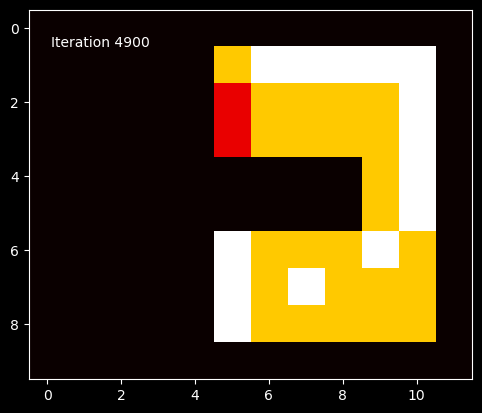

In [15]:
# animate visited tracks    
fig, ax = plt.subplots()
image = plt.imshow(track.course, cmap='hot', interpolation='none')
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

def get_render_func(_track_maps_l):
    def animate(it):
        track_map = _track_maps_l[it]
        #image.set_array(track.course)
        image.set_array(track_map)
        time_text.set_text(f"Iteration {it}")
        return image, time_text
    return animate

def init():
    image.set_array(track.course)
    return [image]

ani = animation.FuncAnimation(fig, get_render_func(track_maps_l), frames=range(0, len(track_maps_l), 100), 
                              interval=100, blit=True, init_func=init)
ani.save("solution_2.gif")


![SegmentLocal](solution_2.gif "segment")

Use the code block directly below to test the resulting deterministic greedy policy (several samples are taken in order to show behavior in all different starting positions).

In [ ]:
pos_maps_over_eps_l = []
no_episodes = 10
for e in range(no_episodes):

    _, _, _, _, pos_map = gather_experience(pi, max_episode_len, deterministic=True)
    pos_map = (pos_map > 0).astype(np.int16)
    pos_map +=  track.course  # overlay track course
    pos_maps_over_eps_l.append(pos_map)


ani = animation.FuncAnimation(fig, get_render_func(pos_maps_over_eps_l),
                              frames=range(0, len(pos_maps_over_eps_l), 1), 
                              interval=500, blit=True, init_func=init)
ani.save("solution_2_2.gif")

MovieWriter ffmpeg unavailable; using Pillow instead.


![SegmentLocal](solution_2_2.gif "segment")